<a href="https://www.kaggle.com/code/keremkosif/disaster-prediction-using-nlp?scriptVersionId=122934182" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Disaster Prediction with Lemmatization and Preprocessing
    In this project, the goal is to develop a model that can accurately identify tweets that are related to a disaster. To achieve this, the tweet data is preprocessed, including removing stop words and punctuation, and performing lemmatization to transform words to their base form. The preprocessed data is then used to train an LSTM model, which is a type of neural network that can process sequential data. The model is designed to predict whether a tweet is related to a disaster or not. Overall, this project aims to demonstrate how natural language processing and machine learning techniques can be used to identify relevant information from social media in the context of disasters.

# Data Loading and Exploration

Importing necessary libraries for data preprocessing and analysis. The libraries include keras for building the deep learning model, stopwords from nltk for removing stop words, re for regular expression, pandas and numpy for data manipulation, matplotlib for data visualization, spacy for lemmatization, tqdm for progress bar visualization and WordCloud for visualizing frequently occurring words. It also sets the logging level of tensorflow to error to prevent excessive logging.

In [1]:
from tensorflow import keras
from nltk.corpus import stopwords
import os
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import spacy
from tqdm import tqdm
from wordcloud import WordCloud

from keras import layers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

tf.get_logger().setLevel('ERROR')

In [2]:
df = pd.read_csv('../input/nlp-getting-started/train.csv')

In [3]:
df.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


## Word Cloud
This code generates a word cloud visualization of the most frequent words in the dataset's text column to gain insight into the common words present in the text data. It also prints a list of stopwords in the English language. Stopwords are common words like "a", "an", "the" etc. that are usually removed from text data as they do not provide significant meaning to the text.*

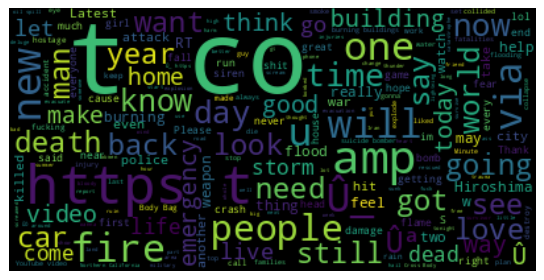

In [4]:
text = "".join(df["text"].to_list())
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(8, 6), dpi=85)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [5]:
cl_df = df.copy()
cl_df = cl_df.drop(["keyword", "location", "id"], axis=1)

# Data Cleaning and Preprocessing

## Step 1: Regular Expression

This code applies several preprocessing techniques to the text column of the dataset:

* It makes a copy of the original DataFrame, removes columns keyword, location, and id, which are not used in the analysis.
* It uses regular expressions to replace non-alphabetic characters in the text with space. This is done to remove any special characters, numbers, or punctuations from the text, which are not useful for analysis.
* It converts all text to lower case to standardize the text data.
* It removes stopwords from the text data, by creating a list of words from the text data that are not in the stop words list.
* It uses spacy to perform lemmatization, which is the process of reducing words to their base form, by stripping away any inflections or suffixes. This is done to reduce the number of unique words in the dataset and group together words with similar meanings. The lemmatized words are joined back together to form the cleaned text column in the DataFrame cl_df.

In [6]:
cl_df["text"] = [re.sub("[^a-zA-Z]", " ", line) for line in cl_df["text"]]
cl_df["text"] = [line.lower() for line in cl_df["text"]]

In [7]:
cachedStopWords = stopwords.words("english")
stopped_list = []
for line in cl_df["text"]:
    text = ' '.join([word for word in line.split() if word not in cachedStopWords])
    stopped_list.append(text)
cl_df["text"] = stopped_list

lemmatizer = spacy.load('en_core_web_sm')
lemmatized_list = []
for line in cl_df["text"]:
    word = " ".join([token.lemma_ for token in lemmatizer(line)])
    lemmatized_list.append(word)
cl_df["text"] = lemmatized_list

### Splitting Data into Training and Validation Sets

In [8]:
X = cl_df["text"]
y = cl_df["target"]

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [9]:
vocab_size = 10000
embedding_dim = 64
max_length = 25
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

## Tokenization and Padding

* Tokenizer class from tensorflow.keras.preprocessing.text is used to tokenize the text data.
* num_words argument specifies the maximum number of words to keep, based on word frequency. The most frequent num_words words will be kept.
* oov_token argument specifies the token to be used for out-of-vocabulary (OOV) words that are not in the vocabulary.
* fit_on_texts() method of the Tokenizer object is used to fit the tokenizer on the training data.
* texts_to_sequences() method of the Tokenizer object is used to convert the text data into sequences of integers.

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)

* pad_sequences() function from tensorflow.keras.preprocessing.sequence module is used to pad the sequences with zeros or truncate them to ensure that all sequences have the same length.
* maxlen argument specifies the maximum length of sequences. If a sequence is shorter than maxlen, it will be padded with zeros. If it is longer, it will be truncated.
* padding_type argument specifies whether to add padding at the beginning or end of the sequence.
* trunc_type argument specifies whether to truncate the sequence at the beginning or end.

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Building the LSTM model

* **Defining the Model Architecture:** This section defines the architecture of the model using Keras API. It starts with creating a sequential model, followed by adding an Embedding layer with vocab_size as the input dimension, 32 as the embedding dimension and max_length as the input length. It then adds a Bidirectional LSTM layer with 32 units. A Dropout layer with 0.25 rate is added to prevent overfitting. BatchNormalization layer is also added to normalize the activations of the previous layer.

* **Adding Dense Layers:** Two dense layers with ReLU activation are added, each followed by a Dropout layer with 0.25 rate and a BatchNormalization layer.

* **Output Layer:** The last layer added to the model is a dense layer with sigmoid activation to predict binary classification output.

* **Compiling the Model:** The model is then compiled with Adam optimizer with a learning rate of 0.0001 and binary cross-entropy as the loss function.

* **Training the Model:** The model is trained on the training data for 50 epochs with a batch size of 32. Early stopping is applied to monitor the validation loss and to stop the training process when the validation loss stops improving. The training progress is also monitored and stored in the history object for future analysis.

In [12]:
emb_model = keras.models.Sequential()
emb_model.add(layers.Embedding(vocab_size, 32, input_length=max_length))
emb_model.add(layers.Bidirectional(layers.LSTM(32)))
emb_model.add(layers.Dropout(0.25))
emb_model.add(layers.BatchNormalization())

emb_model.add(layers.Dense(32, activation='relu'))
emb_model.add(layers.Dropout(0.25))
emb_model.add(layers.BatchNormalization())

emb_model.add(layers.Dense(16, activation='relu'))
emb_model.add(layers.Dropout(0.25))
emb_model.add(layers.BatchNormalization())

emb_model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
optimizer = keras.optimizers.Adam(0.0001)
emb_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', restore_best_weights=True)
history = emb_model.fit(X_train_pad, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_valid_pad, y_valid), callbacks=[earlyStopping])

Epoch 1/50
191/191 [==============================] - 8s 14ms/step - loss: 0.8358 - accuracy: 0.5120 - val_loss: 0.7225 - val_accuracy: 0.4183
Epoch 2/50
191/191 [==============================] - 2s 10ms/step - loss: 0.7455 - accuracy: 0.5673 - val_loss: 0.7064 - val_accuracy: 0.4373
Epoch 3/50
191/191 [==============================] - 2s 9ms/step - loss: 0.6819 - accuracy: 0.6140 - val_loss: 0.6472 - val_accuracy: 0.6264
Epoch 4/50
191/191 [==============================] - 2s 9ms/step - loss: 0.6301 - accuracy: 0.6517 - val_loss: 0.5841 - val_accuracy: 0.7039
Epoch 5/50
191/191 [==============================] - 2s 9ms/step - loss: 0.5824 - accuracy: 0.6929 - val_loss: 0.5358 - val_accuracy: 0.7387
Epoch 6/50
191/191 [==============================] - 2s 9ms/step - loss: 0.5207 - accuracy: 0.7407 - val_loss: 0.5097 - val_accuracy: 0.7715
Epoch 7/50
191/191 [==============================] - 2s 9ms/step - loss: 0.4713 - accuracy: 0.7854 - val_loss: 0.4869 - val_accuracy: 0.7840
Epoc

## Evaluation

Creating a line plot with the number of epochs on the x-axis and the loss values on the y-axis. The red line represents the training loss, while the blue line represents the validation loss. The title(), xlabel(), and ylabel() methods are used to add a title and axis labels to the graph, and the legend() method is used to add a legend to distinguish between the two lines.

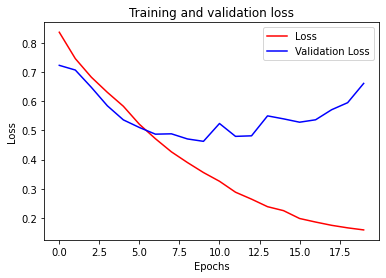

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(len(history.history["loss"]))]

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

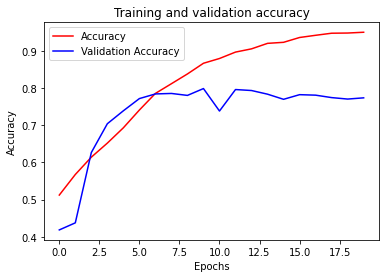

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()